# プロトタイプ（9月）

このプロトタイプは、自動着色と超解像のモジュールを検証する為のものです。

最終の実装と若干異なりますが、最終の実装と同じ出力結果が期待されます。

このプロトタイプは、次のモデルを使います。

- **自動着色**：[Colorful Image Colorization(CIC)](http://richzhang.github.io/colorization/)
- **超解像**：[RealSR ncnn Vulkan](https://github.com/nihui/realsr-ncnn-vulkan)

## 準備

自動着色のモデルはGitHubからのCloneで入手。

In [ ]:
! git clone https://github.com/richzhang/colorization.git

Cloning into 'colorization'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 4873 (delta 24), reused 42 (delta 13), pack-reused 4812
Receiving objects: 100% (4873/4873), 178.34 MiB | 24.02 MiB/s, done.
Resolving deltas: 100% (409/409), done.


RealSR ncnn Vulkan can be download on its [Project Page](https://github.com/nihui/realsr-ncnn-vulkan/releases).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp /content/drive/My\ Drive/Colab\ Notebooks/graduation-research-2021/realsr-ncnn-vulkan-20200818-linux.zip /content/
! unzip realsr-ncnn-vulkan-20200818-linux.zip

Archive:  realsr-ncnn-vulkan-20200818-linux.zip
   creating: realsr-ncnn-vulkan-20200818-linux/
  inflating: realsr-ncnn-vulkan-20200818-linux/readme.txt  
   creating: realsr-ncnn-vulkan-20200818-linux/models-DF2K/
  inflating: realsr-ncnn-vulkan-20200818-linux/models-DF2K/x4.bin  
  inflating: realsr-ncnn-vulkan-20200818-linux/models-DF2K/x4.param  
   creating: realsr-ncnn-vulkan-20200818-linux/models-DF2K_JPEG/
  inflating: realsr-ncnn-vulkan-20200818-linux/models-DF2K_JPEG/x4.bin  
  inflating: realsr-ncnn-vulkan-20200818-linux/models-DF2K_JPEG/x4.param  
  inflating: realsr-ncnn-vulkan-20200818-linux/realsr-ncnn-vulkan  


また、イメージをノートブックに表示する為に次のコマンドを実行します。

In [ ]:
% matplotlib inline

処理を待つ画像もインポートします。

In [ ]:
! cp /content/drive/My\ Drive/Colab\ Notebooks/TensorFlow開発入門/img.zip /content/
! unzip img.zip

## テストデータ

ランダムに画像を選び出します。

In [ ]:
import os
import random

rootdir = "/content/img/colorize/"
file_names = []
for parent, dirnames, filenames in os.walk(rootdir): 
    file_names = filenames
x = random.randint(0, len(file_names)-1)
img_name = '/content/img/colorize/' + file_names[x]
print(img_name)

/content/img/colorize/a8139a1d2f79b8df.jpg


選び出した画像を表示します。

(-0.5, 223.5, 223.5, -0.5)

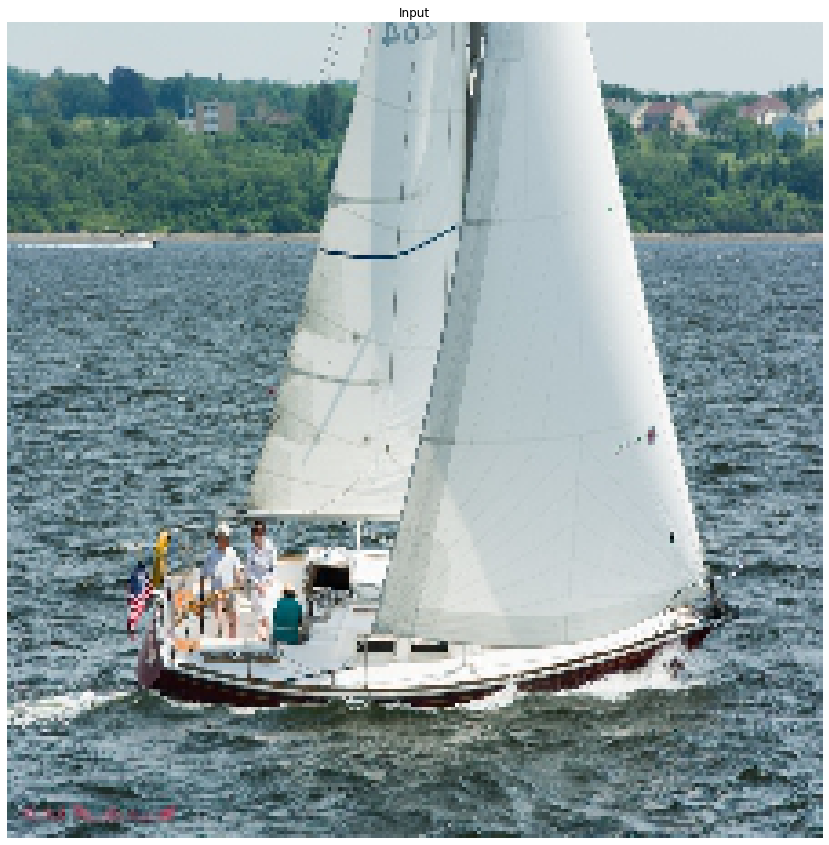

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

plt.figure(figsize=(15, 15))
plt.imshow(load_img(img_name))
plt.title('Input')
plt.axis('off')

## 自動着色

GPUを使用して自動着色を実行します。

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Oct  5 13:08:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


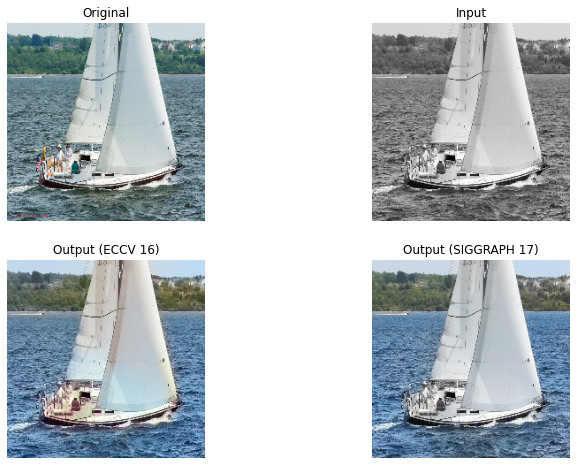

In [ ]:
from colorization.colorizers import *

# load colorizers
colorizer_eccv16 = eccv16(pretrained=True).eval()
colorizer_siggraph17 = siggraph17(pretrained=True).eval()
# set GPU
colorizer_eccv16.cuda()
colorizer_siggraph17.cuda()

# default size to process images is 256x256
# grab L channel in both original ("orig") and resized ("rs") resolutions
img = load_img(img_name)
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))
# set GPU
tens_l_rs = tens_l_rs.cuda()

# colorizer outputs 256x256 ab map
# resize and concatenate to original L channel
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())
out_img_siggraph17 = postprocess_tens(tens_l_orig, colorizer_siggraph17(tens_l_rs).cpu())

plt.imsave('eccv16.jpg', out_img_eccv16)
plt.imsave('siggraph17.jpg', out_img_siggraph17)
plt.imsave('img_bw.jpg', img_bw)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_bw)
plt.title('Input')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(out_img_eccv16)
plt.title('Output (ECCV 16)')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(out_img_siggraph17)
plt.title('Output (SIGGRAPH 17)')
plt.axis('off')
plt.show()

## 超解像

次は前節の出力ファイルに超解像処理を行います。

まずは準備を行います。

In [ ]:
! apt install libvulkan-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libvulkan1 mesa-vulkan-drivers
The following NEW packages will be installed:
  libvulkan-dev libvulkan1 mesa-vulkan-drivers
0 upgraded, 3 newly installed, 0 to remove and 22 not upgraded.
Need to get 3,632 kB of archives.
After this operation, 22.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 mesa-vulkan-drivers amd64 20.0.8-0ubuntu1~18.04.1 [3,059 kB]
Get:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic/main amd64 libvulkan1 amd64 1.1.126.0-2~gpu18.04.1 [101 kB]
Get:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic/main amd64 libvulkan-dev amd64 1.1.126.0-2~gpu18.04.1 [472 kB]
Fetched 3,632 kB in 0s (11.8 MB/s)
Selecting previously unselected package libvulkan1:amd64.
(Reading database ... 144618 files and directories currently installed.)
Prepari

前節の出力ファイルを移動します。

In [ ]:
! cp /content/siggraph17.jpg /content/realsr-ncnn-vulkan-20200818-linux/
% cd /content/realsr-ncnn-vulkan-20200818-linux/

/content/realsr-ncnn-vulkan-20200818-linux


`siggraph17.jpg`に超解像処理を行います。

In [ ]:
! ./realsr-ncnn-vulkan -i siggraph17.jpg -o siggraph17_out.jpg

[0 Tesla V100-SXM2-16GB]  queueC=2[8]  queueG=0[16]  queueT=1[1]
[0 Tesla V100-SXM2-16GB]  bugsbn1=0  buglbia=0  bugcopc=0  bugihfa=0
[0 Tesla V100-SXM2-16GB]  fp16p=1  fp16s=1  fp16a=1  int8s=1  int8a=1
0.00%
25.00%
50.00%
75.00%


## 出力結果の確認

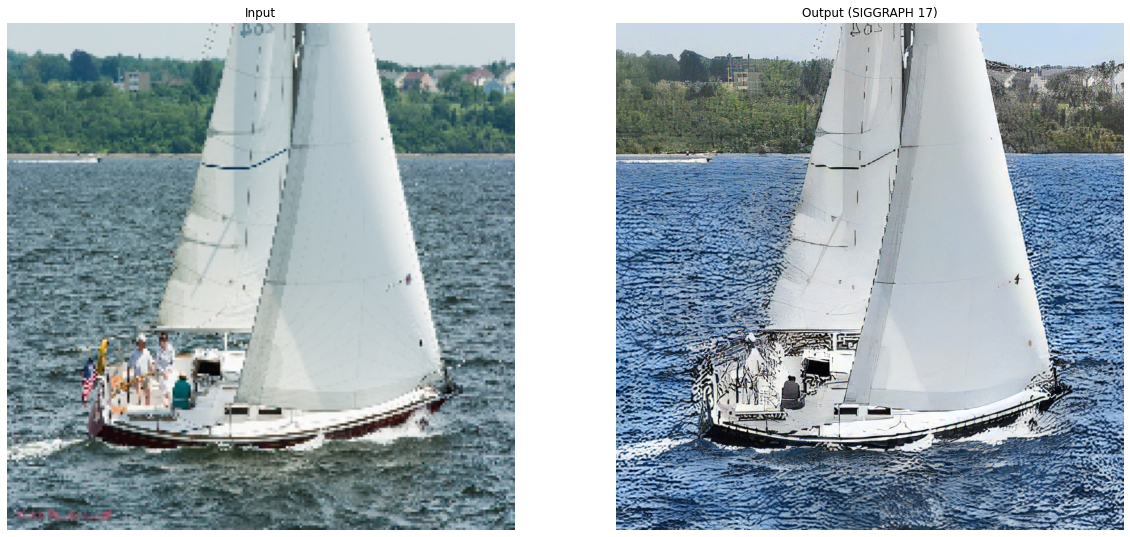

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(load_img(img_name))
plt.title('Input')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(load_img('/content/realsr-ncnn-vulkan-20200818-linux/siggraph17_out.jpg'))
plt.title('Output (SIGGRAPH 17)')
plt.axis('off')
plt.show()

## 更に超解像を行うと…

In [ ]:
! ./realsr-ncnn-vulkan -i siggraph17_out.jpg -o siggraph17_out_8x.jpg

[0 Tesla V100-SXM2-16GB]  queueC=2[8]  queueG=0[16]  queueT=1[1]
[0 Tesla V100-SXM2-16GB]  bugsbn1=0  buglbia=0  bugcopc=0  bugihfa=0
[0 Tesla V100-SXM2-16GB]  fp16p=1  fp16s=1  fp16a=1  int8s=1  int8a=1
0.00%
4.00%
8.00%
12.00%
16.00%
20.00%
24.00%
28.00%
32.00%
36.00%
40.00%
44.00%
48.00%
52.00%
56.00%
60.00%
64.00%
68.00%
72.00%
76.00%
80.00%
84.00%
88.00%
92.00%
96.00%


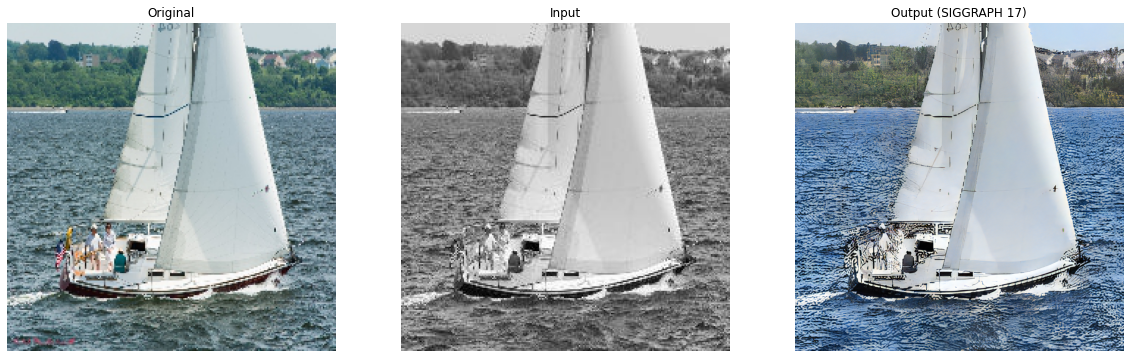

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(1,3,1)
plt.imshow(load_img(img_name))
plt.title('Original')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(load_img('/content/img_bw.jpg'))
plt.title('Input')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(load_img('/content/realsr-ncnn-vulkan-20200818-linux/siggraph17_out_8x.jpg'))
plt.title('Output (SIGGRAPH 17)')
plt.axis('off')
plt.show()